<a href="https://colab.research.google.com/github/Mishra-0709/Createch-2025/blob/main/Construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1587613

    accuracy                           1.00   1587613
   macro avg       1.00      1.00      1.00   1587613
weighted avg       1.00      1.00      1.00   1587613



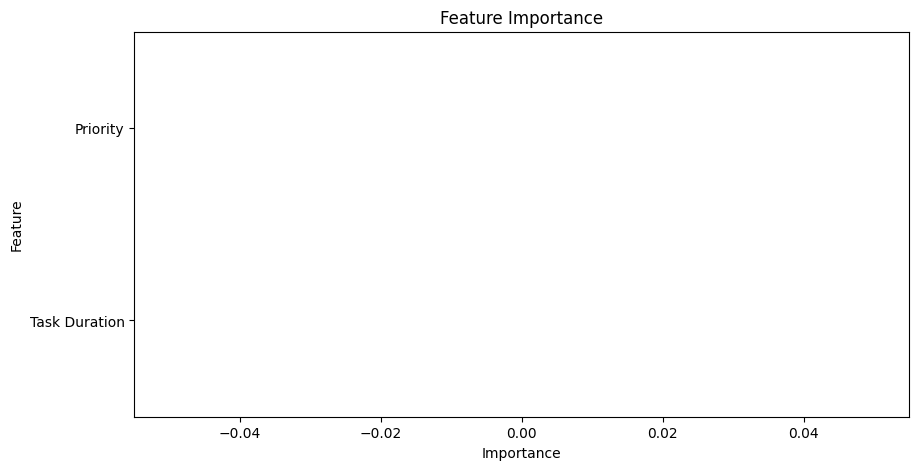

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


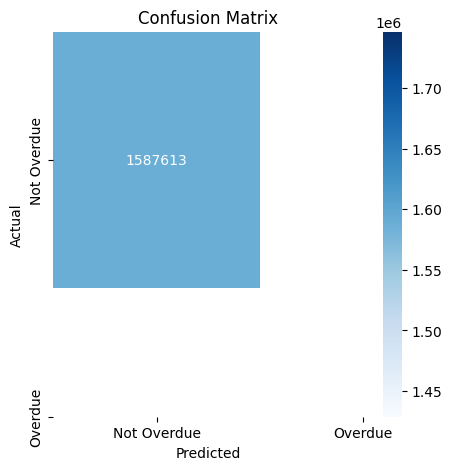

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets with correct columns
df_forms = pd.read_csv("/content/Construction_Data_PM_Forms_All_Projects.csv",
                        usecols=['Project', 'Created', 'Status Changed', 'OverDue'],
                        dayfirst=True)
df_tasks = pd.read_csv("/content/Construction_Data_PM_Tasks_All_Projects.csv",
                        usecols=['project', 'Created', 'Status Changed', 'Priority', 'Task Group'],
                        dayfirst=True)

# Rename project column in df_tasks to match df_forms
df_tasks.rename(columns={'project': 'Project'}, inplace=True)

# Merge datasets on 'Project'
df = pd.merge(df_forms, df_tasks, on='Project', how='inner')

# Convert date columns to datetime
date_cols = ['Created_x', 'Created_y', 'Status Changed_x', 'Status Changed_y']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

# Feature Engineering
if 'Status Changed_y' in df.columns and 'Created_y' in df.columns:
    df['Task Duration'] = (df['Status Changed_y'] - df['Created_y']).dt.days
    df.dropna(subset=['Task Duration'], inplace=True)

# Ensure OverDue column exists and rename if necessary
if 'OverDue' in df.columns:
    df.rename(columns={'OverDue': 'OverDue_x'}, inplace=True)

# Optimize memory usage
for col in ['OverDue_x']:
    if col in df.columns:
        df[col] = df[col].astype(bool)
for col in ['Priority', 'Task Group']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Encode categorical variables
label_encoders = {}
categorical_columns = [col for col in ['Priority', 'Task Group'] if col in df.columns]
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Select features and target
available_features = [col for col in ['Priority', 'Task Duration'] if col in df.columns]
target = 'OverDue_x' if 'OverDue_x' in df.columns else None

if target and target in df.columns:
    X = df[available_features]
    y = df[target].astype(int)

    # Use only a subset of data to reduce RAM usage
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.3, random_state=42)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train model
    clf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10)
    clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Feature Importance
    importances = clf.feature_importances_
    feature_names = available_features
    if len(importances) > 0:
        plt.figure(figsize=(10, 5))
        sns.barplot(x=importances, y=feature_names)
        plt.title("Feature Importance")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Overdue', 'Overdue'], yticklabels=['Not Overdue', 'Overdue'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

else:
    print("Error: Target variable 'OverDue_x' not found in dataset.")
